## **Aequitas**

En este notebook se presenta la herramienta de auditoría de sesgo **Aequitas**, la cual permite a los usuarios probar modelos con diferentes métricas de sesgo y equidad en relación con múltiples grupos de población. La herramienta facilita la toma de decisiones informada y equitativa sobre el desarrollo y la implementación de herramientas predictivas.

En este caso particular, se analizará el conjunto de datos [COMPAS](https://www.propublica.org/datastore/dataset/compas-recidivism-risk-score-data-and-analysis) de ProPublica, sobre la evaluación del riesgo de reincidencia.

**<font color="#04a6aa"> Este caso es de caracter punitivo y por lo tanto las metricas de falsos positivos tiene más importancia</font>**


* *Para más información sobre este ejemplo visite este [enlace](https://dssg.github.io/aequitas/examples/compas_demo.html).*

* *Para más información sobre la herramienta Aequitas visite este [enlace](http://aequitas.dssg.io/).*

* *Ver [Reporte de Sesgo](http://aequitas.dssg.io/example.html) con Aequitas Web App*

### Librerias

In [ ]:
%pip install -q --upgrade aequitas

In [1]:
import pandas as pd
import seaborn as sns
import warnings
import matplotlib

from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
import aequitas.plot as ap
from aequitas.plotting import Plot

warnings.simplefilter('ignore')

pd.set_option('display.max_columns', None)

%matplotlib inline

### Dataset

"Northpointe's COMPAS (Correctional Offender Management Profiling for Alternative Sanctions o Perfil de Gestión de Delincuentes Correccionales para Sanciones Alternativas, en español) es una de las herramientas/algoritmos de evaluación de riesgos más ampliamente utilizados dentro del sistema de justicia penal para guiar decisiones como la forma de establecer una fianza".

La columna `score` corresponde a la etiqueta predicha por el modelo.

La columna `label_value` corresponde a la etiqueta a predecir o etiqueta verdadera.

In [2]:
df = pd.read_csv("https://github.com/dssg/aequitas/raw/master/examples/data/compas_for_aequitas.csv")
df.head(10)

,entity_id,score,label_value,race,sex,age_cat
0,1,0.0,0,Other,Male,Greater than 45
1,3,0.0,1,African-American,Male,25 - 45
2,4,0.0,1,African-American,Male,Less than 25
3,5,1.0,0,African-American,Male,Less than 25
4,6,0.0,0,Other,Male,25 - 45
5,7,0.0,0,Other,Male,25 - 45
6,8,1.0,1,Caucasian,Male,25 - 45
7,9,0.0,0,Other,Male,25 - 45
8,10,0.0,0,Caucasian,Female,25 - 45
9,13,0.0,1,Caucasian,Male,Less than 25


In [3]:
print(f"Cantidad de registro del dataset: {df.shape[0]}.")
print(f"Numero de caracteristicas: {df.shape[1]}.")

Cantidad de registro del dataset: 7214.
Numero de caracteristicas: 6.


In [ ]:
df.info()

#### Explorando COMPAS

**Evaluación de riesgos por raza**

"COMPAS produce una puntuación de riesgo que predice la probabilidad de que una persona cometa un delito en los próximos dos años. El resultado es una puntuación entre 1 y 10 que se asigna a 'bajo', 'medio' o 'alto'. Para usar Aequitas, colapsamos esto en una predicción binaria. Una puntuación de 0 indica una predicción de riesgo 'bajo' según COMPAS, mientras que un 1 indica riesgo 'alto' o 'medio' ".

- *Esta categorización se basa en la interpretación de ProPublica de la guía para profesionales de Northpointe: "De acuerdo con la guía para profesionales de Northpointe, los puntajes COMPAS en el rango medio y alto atraen más interés de las agencias de supervisión que los puntajes bajos, ya que un puntaje bajo sugeriría que hay poco riesgo de reincidencia general, por lo que consideramos puntajes más altos que 'bajos' para indicar un riesgo de reincidencia."*

"En los gráficos de barras a continuación, vemos una gran diferencia en cómo estos puntajes se distribuyen por raza, con una mayoría de personas blancas e hispanas pronosticadas como de bajo riesgo (`score = 0`) y una mayoría de personas negras pronosticadas con riesgo alto y medio (`score = 1`). También vemos que mientras que la mayoría de las personas en las categorías de edad mayores de 25 años se predicen como de bajo riesgo (`score = 0`), la mayoría de las personas menores de 25 años se predicen como de riesgo alto y medio (`score = 1`)".

In [4]:
# Paleta de colores de aequitas (opcional)
aq_palette = sns.diverging_palette(225, 35, n=2)

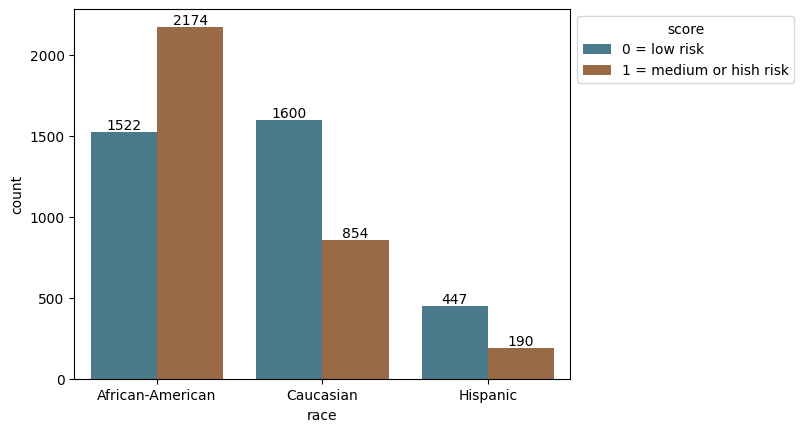

In [5]:
by_race = sns.countplot(x="race",
                        hue="score",
                        data=df[df.race.isin(['African-American', 'Caucasian', 'Hispanic'])],
                        palette=aq_palette)

for label in by_race.containers:
    by_race.bar_label(label)

by_race.legend(title='score', labels=['0 = low risk', '1 = medium or hish risk'], loc='upper left', bbox_to_anchor=(1, 1))

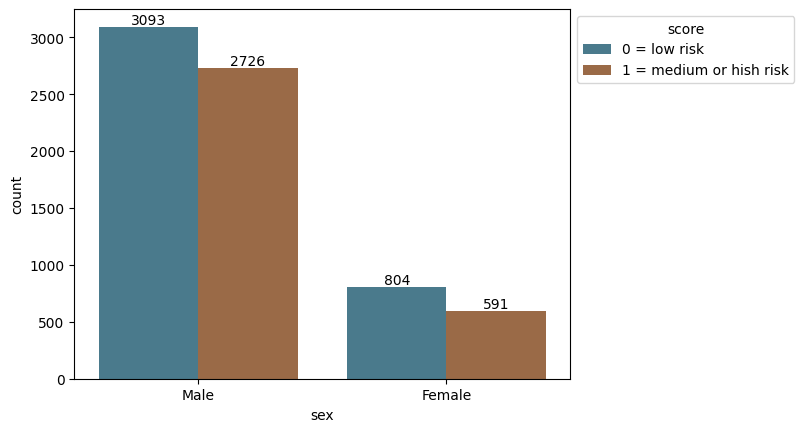

In [6]:
by_sex = sns.countplot(x="sex", hue="score", data=df, palette=aq_palette)

for label in by_sex.containers:
    by_sex.bar_label(label)

by_sex.legend(title='score', labels=['0 = low risk', '1 = medium or hish risk'], loc='upper left', bbox_to_anchor=(1, 1))

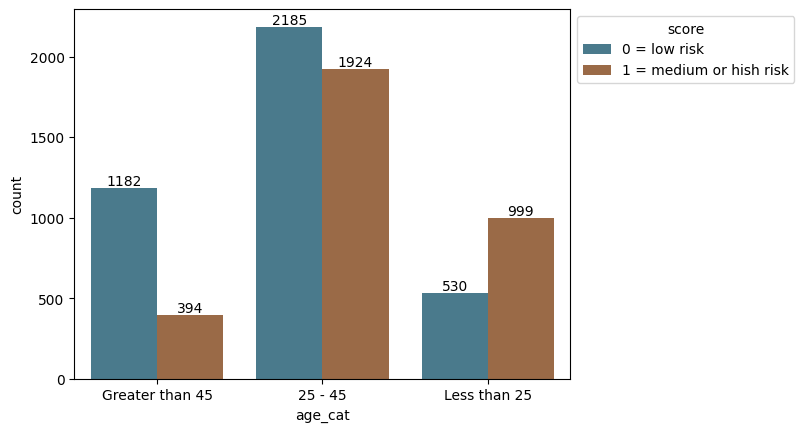

In [7]:
by_age = sns.countplot(x="age_cat", hue="score", data=df, palette=aq_palette)

for label in by_age.containers:
    by_age.bar_label(label)

by_age.legend(title='score', labels=['0 = low risk', '1 = medium or hish risk'], loc='upper left', bbox_to_anchor=(1, 1))

**Niveles de reincidencia. ¿La persona reincidió?**

"Este conjunto de datos incluye información sobre si el sujeto reincidió o no, por lo que podemos probar directamente el 'accuracy' de las predicciones".

Primero, visualizamos las tasas de reincidencia por raza.

"Siguiendo a ProPublica, definimos la reincidencia como un nuevo arresto dentro de dos años. (Si una persona reincide `label_value = 1`).

- *ProPublica basó esta decisión en la guía para profesionales de Northpointe, que dice que su puntaje de reincidencia está destinado a predecir un nuevo delito menor o mayor dentro de los dos años posteriores a la fecha de administración de COMPAS".*

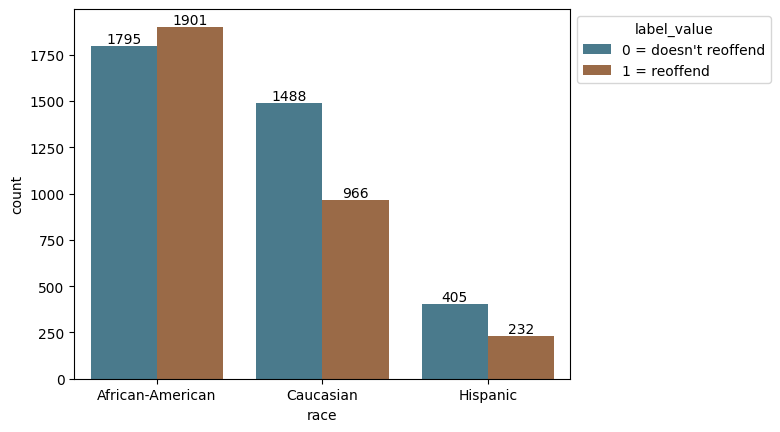

In [8]:
# Grafico de reincidencia según la raza
label_by_race = sns.countplot(x="race",
                              hue="label_value",
                              data=df[df.race.isin(['African-American', 'Caucasian', 'Hispanic'])],
                              palette=aq_palette)

for label in label_by_race.containers:
    label_by_race.bar_label(label)

label_by_race.legend(title='label_value', labels=["0 = doesn't reoffend", '1 = reoffend'], loc='upper left', bbox_to_anchor=(1, 1))

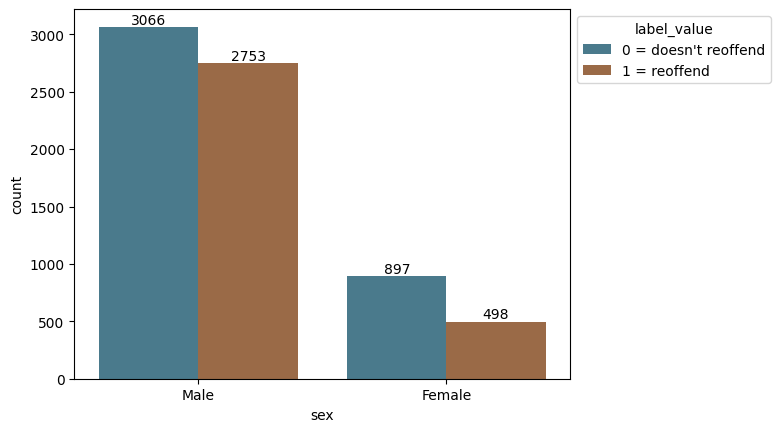

In [9]:
# Grafico de reincidencia segun el sexo
label_by_sex = sns.countplot(x="sex", hue="label_value", data=df, palette=aq_palette)

for label in label_by_sex.containers:
    label_by_sex.bar_label(label)

label_by_sex.legend(title='label_value', labels=["0 = doesn't reoffend", '1 = reoffend'], loc='upper left', bbox_to_anchor=(1, 1))

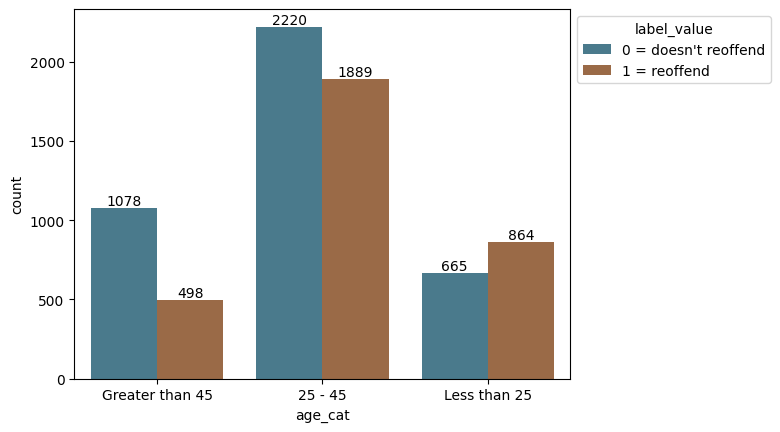

In [10]:
# Grafico de reincidencia segun la edad
label_by_age = sns.countplot(x="age_cat", hue="label_value", data=df, palette=aq_palette)

for label in label_by_age.containers:
    label_by_age.bar_label(label)

label_by_age.legend(title='label_value', labels=["0 = doesn't reoffend", '1 = reoffend'], loc='upper left', bbox_to_anchor=(1, 1))

"Los gráficos anteriores muestran que las tasas base de reincidencia ($TBR$) son más altas para los acusados negros en comparación con los blancos (0.51 frente a 0.39), aunque las predicciones ($Pred$) no coinciden con las tasas base".

- **Predicciones:**

\begin{equation}
Pred_{blancos} = \dfrac{854}{854+1600} = 34.8\%
\end{equation}
$
$
\begin{equation}
Pred_{negros} = \dfrac{2174}{2174+1522} = 58.8\%
\end{equation}

- **Tasas base (realidad):**

\begin{equation}
TBR_{blancos} = \dfrac{966}{966+1488} = 39.3\% \,\, \color{red}{⇑}
\end{equation}
$
$
\begin{equation}
TBR_{negros} = \dfrac{1901}{1901+1759} = 51.4\% \,\, \color{green}{⇓}
\end{equation}

### Trabajando con Aequitas

"Los profesionales se enfrentan al desafío de determinar si dichos patrones reflejan o no un sesgo. El hecho de que haya múltiples formas de medir el sesgo agrega complejidad al proceso de toma de decisiones. Con Aequitas, es posible automatizar el informe de varias métricas de equidad para ayudar en este proceso".

Para usar Aequitas utilizando programación es necesario seguir un proceso de tres pasos representado por tres clases de Python:

`Group()`: Definir grupos

`Bias()`: Calcular disparidades

`Fairness()`: Afirmar la equidad

Cada clase se basa en la anterior expandiendo el DataFrame de salida.

*Nota: Para visualizar las métricas se utiliza la clase `Plot()`.*

#### Formateo de datos

"Los datos de este ejemplo se preprocesaron para que fueran compatibles con Aequitas. **La herramienta Aequitas siempre requiere una columna `score` y una columna binaria `label_value` para las métricas supervisadas** (es decir, Tasa de Falsos Descubrimientos (FDR), Tasa de Falsos Positivos (FPR), Tasa de Falsas Omisiones (FOR) y Tasa de Falsos Negativos (FNR))".

- *Para más información sobre estas métricas visite los siguientes enlaces: [Sesgo y Equidad](https://textbook.coleridgeinitiative.org/chap-bias.html), [Aequitas](https://github.com/dssg/aequitas#aequitas-group-metrics), [FPR vs FDR](https://stats.stackexchange.com/questions/336455/fpr-false-positive-rate-vs-fdr-false-discovery-rate), [Some Useful Statistics Definitions](https://www.cs.rpi.edu/~leen/misc-publications/SomeStatDefs.html), [Performance Metrics: False Omission Rate](https://www.roelpeters.be/glossary/false-omission-rate/#:~:text=Given%20a%20negative%20prediction%2C%20the,is%20the%20Negative%20Predictive%20Value)*.

"El preprocesamiento incluye, entre otros, la comprobación de las columnas `score` y `label_value` obligatorias, así como al menos una columna que representa atributos específicos del conjunto de datos. Consulte la [documentación](https://dssg.github.io/aequitas/) para obtener más información sobre los datos de entrada".

"Tenga en cuenta que, si bien `entity_id` no es necesario para este ejemplo, Aequitas lo reconoce como un nombre de columna de reserva y no lo reconocerá como una columna de atributos".

#### ¿Qué sesgos existen en mi modelo?

##### **Clase Group() de Aequitas**

##### **¿Cuál es la distribución de grupos, puntajes (scores) previstos y etiquetas (labels) en mi conjunto de datos?**

"La clase `Group()` de Aequitas permite a los investigadores evaluar los sesgos en todos los subgrupos de su conjunto de datos mediante el ensamblaje de una matriz de confusión de cada subgrupo, el cálculo de métricas de uso común, como la Tasa de Falsos Positivos (FPR) y la Tasa de Falsas Omisiones (FOR), así como los recuentos por grupo y la prevalencia$^{1}$ de grupo entre la población de la muestra".

"El método `get_crosstabs()` tabula una matriz de confusión para cada subgrupo y calcula las métricas de uso común (p. ej. FOR o FPR). También proporciona conteos por grupos y prevalencias de grupos".

*$^{1}$ La prevalencia es la fracción de individuos con etiqueta positiva o en este caso la tasa de ser verdaderamente culpable.*

**Recuentos de grupos calculados (Group Counts):**

<table>
<colgroup>
<col style="width: 62%">
<col style="width: 38%">
</colgroup>
<thead>
<tr class="row-odd"><th class="head"><p>Count Type</p></th>
<th class="head"><p>Column Name</p></th>
</tr>
</thead>
<tbody>
<tr class="row-even"><td><p>False Positive Count</p></td>
<td><p>‘fp’</p></td>
</tr>
<tr class="row-odd"><td><p>False Negative Count</p></td>
<td><p>‘fn’</p></td>
</tr>
<tr class="row-even"><td><p>True Negative Count</p></td>
<td><p>‘tn’</p></td>
</tr>
<tr class="row-odd"><td><p>True Positive Count</p></td>
<td><p>‘tp’</p></td>
</tr>
<tr class="row-even"><td><p>Predicted Positive Count</p></td>
<td><p>‘pp’</p></td>
</tr>
<tr class="row-odd"><td><p>Predicted Negative Count</p></td>
<td><p>‘pn’</p></td>
</tr>
<tr class="row-even"><td><p>Count of Negative Labels in Group</p></td>
<td><p>‘group_label_neg’</p></td>
</tr>
<tr class="row-odd"><td><p>Count of Positive Labels in Group</p></td>
<td><p>‘group_label_pos’</p></td>
</tr>
<tr class="row-even"><td><p>Group Size</p></td>
<td><p>‘group_size’</p></td>
</tr>
<tr class="row-odd"><td><p>Total Entities</p></td>
<td><p>‘total_entities’</p></td>
</tr>
</tbody>
</table>

**Métricas absolutas calculadas (Absolute Metrics):**

<table class="docutils align-center">
<colgroup>
<col style="width: 73%">
<col style="width: 27%">
</colgroup>
<thead>
<tr class="row-odd"><th class="head"><p>Metric</p></th>
<th class="head"><p>Column Name</p></th>
</tr>
</thead>
<tbody>
<tr class="row-even"><td><p>True Positive Rate</p></td>
<td><p>‘tpr’</p></td>
</tr>
<tr class="row-odd"><td><p>True Negative Rate</p></td>
<td><p>‘tnr’</p></td>
</tr>
<tr class="row-even"><td><p>False Omission Rate</p></td>
<td><p>‘for’</p></td>
</tr>
<tr class="row-odd"><td><p>False Discovery Rate</p></td>
<td><p>‘fdr’</p></td>
</tr>
<tr class="row-even"><td><p>False Positive Rate</p></td>
<td><p>‘fpr’</p></td>
</tr>
<tr class="row-odd"><td><p>False Negative Rate</p></td>
<td><p>‘fnr’</p></td>
</tr>
<tr class="row-even"><td><p>Negative Predictive Value</p></td>
<td><p>‘npv’</p></td>
</tr>
<tr class="row-odd"><td><p>Precision</p></td>
<td><p>‘precision’</p></td>
</tr>
<tr class="row-even"><td><p>Predicted Positive Ratio$_k$</p></td>
<td><p>‘ppr’</p></td>
</tr>
<tr class="row-odd"><td><p>Predicted Positive Ratio$_g$</p></td>
<td><p>‘pprev’</p></td>
</tr>
<tr class="row-even"><td><p>Group Prevalence</p></td>
<td><p>‘prev’</p></td>
</tr>
</tbody>
</table>

"Nota: El método `get_crosstabs()` espera un Dataframe con columnas predefinidas `score` y `label_value`, tambien trata/maneja otras columnas (con algunas excepciones) como atributos contra los cuales probar las disparidades. En este caso, incluimos `race`, `sex` y `age_cat`:

In [ ]:
g = Group()
xtab, _ = g.get_crosstabs(df)

In [ ]:
xtab.shape

##### **¿Qué son las métricas de sesgo entre grupos?**

Una vez que haya ejecutado el método `get_crosstabs()` de la clase `Group()`, tendrá un dataframe (`xtab`) de los recuentos de grupos (Group Counts) y las métricas de sesgo de valor de grupo (Absolute Metrics).

In [ ]:
# Dataframe con los recuentos de grupos y las métricas métricas de sesgo entre grupos
xtab.head(11)

La clase `Group()` tiene un método `list_absolute_metrics()`, que puede usar para un corte más rápido para ver solo recuentos o métricas de sesgo.

In [ ]:
# Método list_absolute_metrics(), que puede usar para un corte más rápido para ver solo recuentos o métricas de sesgo.
absolute_metrics = g.list_absolute_metrics(xtab)

In [ ]:
absolute_metrics

**Ver los recuentos de grupos (Group Counts) calculados de población de la muestra:**

In [ ]:
df_group_counts_metrics = xtab[[col for col in xtab.columns if col not in absolute_metrics]]
df_group_counts_metrics.head(11)

**Ver las métricas absolutas (Absolute Metrics) calculadas para cada grupo de población de la muestra:**

In [ ]:
df_absolute_metrics = xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)
df_absolute_metrics.head(11)

##### **¿Cómo interpreto los sesgos en mi modelo?**

En el segmento del Dataframe de tabulación cruzada (`xtab`) creado por el método `get_crosstabs()` de la clase `Group()`, vemos que los afroamericanos tienen una tasa de falsos positivos (`fpr`) del **45%**, mientras que los caucásicos tienen una tasa de falsos positivos (`fpr`) de solo el **23%**.

**Esto significa que las personas afroamericanas tienen muchas más probabilidades de ser etiquetadas falsamente como de alto riesgo que las personas blancas.**

"Por otro lado, las tasas de falsa omisión (`for`) y las tasas de falso descubrimiento (`fdr`) son mucho más cercanas para esos dos grupos (35% vs 29% y 37% vs 41%)".

**Recordemos que:**

- La tasa de falsos positivos (`fpr`) hace referencia a las personas que **NO** deberían estar sujetas a la intervención (ser etiquetadas como de 'alto riesgo').

  Aquí, esto preguntaría, "para una persona inocente, ¿cuáles son las posibilidades de que sean condenados injustamente en virtud del hecho de que son miembros de un grupo determinado?"

  Definición: fracción de individuos con etiquetas reales negativas que el modelo clasifica erróneamente con una etiqueta predicha positiva.

- La tasa de falso descubrimiento (`fdr`) es la fracción de individuos que el modelo predice que tendrán una etiqueta positiva pero para quienes la etiqueta real es negativa.

- La tasa de falsa omisión (`for`) es la fracción de individuos que el modelo predice que tendrán una etiqueta negativa pero para quienes la etiqueta real es positiva.

##### **¿Cómo visualizo el sesgo en mi modelo?**

Las métricas de sesgo de grupo absoluto del dataframe de tabulación cruzada (`xtab)` creado por el metodo `get_crosstabs()` de la clase `Group()` se pueden visualizar con dos métodos en la clase `Plot()`.

Se puede especificar una métrica con `plot_group_metric()`, o se puede trazar una lista de métricas particulares de interés (o todas las métricas) con `plot_group_metric_all()`.

In [ ]:
aqp = Plot()

**Visualización de una única métrica de grupo absoluta en todos los grupos de población:**

El siguiente gráfico muestra la tasa de falsos negativos (`fnr`) de la métrica del grupo calculada en cada atributo, coloreada según el número de muestras en el grupo de atributos.

Podemos ver en las barras más largas que en los atributos `age_cat`, `sex` y `race`, los grupos que COMPAS predice incorrectamente como de riesgo 'bajo' o 'medio' con mayor frecuencia son de 25 a 45 años, hombres y afroamericanos. Por el color más oscuro, también podemos decir que estas son las tres poblaciones más grandes en el conjunto de datos.

In [ ]:
fnr = aqp.plot_group_metric(xtab, 'fnr')

**Ver métricas de grupo solo para grupos por encima de un cierto umbral de tamaño:**

Los tamaños de grupo extremadamente pequeños aumentan el error estándar de las estimaciones y podrían ser factores en el error de predicción, como los falsos negativos.

Utilice el parámetro `min_group` para visualizar solo aquellos grupos de población de muestra por encima de un porcentaje especificado por el usuario del tamaño total de la muestra. Cuando eliminamos grupos por debajo del 5% del tamaño de la muestra, nos quedan solo dos de los seis grupos de raza (`race`), ya que hay grupos mucho más pequeños en esa categoría de atributo que en sexo (`sex`) o categoría de edad (`age_cat`).

In [ ]:
fnr = aqp.plot_group_metric(xtab, 'fnr', min_group_size=0.05)

Tasa de Falsos Positivos

In [ ]:
fpr = aqp.plot_group_metric(xtab, 'fpr')

###### **Otras visualizaciones**

**Visualización de múltiples métricas de grupo absolutas especificadas por el usuario en todos los grupos de población**

Los gráficos a continuación muestran todas las métricas de grupo calculadas en cada atributo, coloreadas según la magnitud absoluta de la métrica.

Podemos ver que el grupo de raza más grande, los afroamericanos, se pronostican/predicen positivos con más frecuencia que cualquier otro grupo racial (tasa positiva predicha `PPR` de 0.66), y es más probable que se clasifiquen incorrectamente como de riesgo 'alto' (tasa de falsos positivos `FPR` de 0.45) que incorrectamente clasificado como riesgo 'bajo' o 'medio' (tasa de falsos negativos `FNR` de 0.28).

Tenga en cuenta que los nativos americanos se pronostican/predicen positivos con una prevalencia `PPREV` más alta en relación con el tamaño de su grupo que todos los demás "grupos raciales" (prevalencia predicha de 0.67).

In [ ]:
p = aqp.plot_group_metric_all(xtab, metrics=['ppr','pprev','fnr','fpr'], ncols=2)

**Visualización de métricas de grupo absolutas predeterminadas en todos los grupos de población**

**Métricas de grupo absolutas predeterminadas**

Al visualizar más de una métrica de grupo absoluto, puede especificar una lista de métricas, especificar todas (`all`) las métricas o usar las métricas predeterminadas de Aequitas al no proporcionar un argumento:
- Disparidad de tasa de grupo positiva predicha (`pprev`),
- Disparidad de tasa positiva predicha (`ppr`),
- Tasa de falso descubrimiento (`fdr`),
- Tasa de falsa omisión (`for`)
- Tasa de falso positivo (`fpr`)
- Tasa de falso negativo (`fnr`)

Los gráficos a continuación muestran las métricas de grupo predeterminadas calculadas en cada atributo, coloreadas según la cantidad de muestras en el grupo de atributos.

Tenga en cuenta que la categoría de edad más de 45 años tiene casi el doble de probabilidades de ser incluida incorrectamente en un grupo de intervención (tasa de falso descubrimiento `FDR` de 0.46) que de exclusión incorrecta de la intervención (tasa de falsa omisión `FOR` 0,24). También podemos ver que el modelo tiene la misma probabilidad de predecir que una mujer tiene un riesgo "alto" como lo es para un hombre (tasa de falsos positivos `FPR` de 0.32 tanto para hombres como para mujeres).

In [ ]:
a = aqp.plot_group_metric_all(xtab, ncols=3)

-----------

#### **¿Qué niveles de disparidad existen entre los grupos de población?**

**Clase Bias() de Aequitas**

"Usamos la clase Aequitas `Bias()` para calcular las disparidades entre grupos en función de la tabulación cruzada (`xtab`) devuelta por el método `get_crosstabs()` de la clase `Group()` descrito anteriormente.

**Las disparidades se calculan como una proporción de una métrica para un grupo de interés en comparación con un grupo base"**.

Por ejemplo, la Disparidad de tasa de falsos negativos (`fnr_disparity`) para los acusados negros frente a los blancos es:

$$Disparity_{FNR} =  \frac{FNR_{black}}{FNR_{white}}$$

"A continuación, usamos `get_disparity_predefined_groups()` que nos permite elegir grupos de referencia que aclaran el resultado para el profesional".

"La clase `Bias()` incluye dos funciones adicionales de obtención de disparidad: `get_disparity_major_group()` y `get_disparity_min_metric()`, que automatizan la selección del grupo base en función de la mayoría de la muestra (en cada atributo) y el valor mínimo para cada métrica de sesgo calculada, respectivamente".

"`get_disparity_predefined_groups()` permite al usuario definir un grupo base para cada atributo, como se ilustra a continuación".

**Disparidades calculadas:**

<table class="docutils align-center">
<colgroup>
<col style="width: 66%">
<col style="width: 34%">
</colgroup>
<thead>
<tr class="row-odd"><th class="head"><p>Metric</p></th>
<th class="head"><p>Column Name</p></th>
</tr>
</thead>
<tbody>
<tr class="row-even"><td><p>True Positive Rate Disparity</p></td>
<td><p>‘tpr_disparity’</p></td>
</tr>
<tr class="row-odd"><td><p>True Negative Rate</p></td>
<td><p>‘tnr_disparity’</p></td>
</tr>
<tr class="row-even"><td><p>False Omission Rate</p></td>
<td><p>‘for_disparity’</p></td>
</tr>
<tr class="row-odd"><td><p>False Discovery Rate</p></td>
<td><p>‘fdr_disparity’</p></td>
</tr>
<tr class="row-even"><td><p>False Positive Rate</p></td>
<td><p>‘fpr_disparity’</p></td>
</tr>
<tr class="row-odd"><td><p>False NegativeRate</p></td>
<td><p>‘fnr_disparity’</p></td>
</tr>
<tr class="row-even"><td><p>Negative Predictive Value</p></td>
<td><p>‘npv_disparity’</p></td>
</tr>
<tr class="row-odd"><td><p>Precision Disparity</p></td>
<td><p>‘precision_disparity’</p></td>
</tr>
<tr class="row-even"><td><p>Predicted Positive Ratio$_k$ Disparity</p></td>
<td><p>‘ppr_disparity’</p></td>
</tr>
<tr class="row-odd"><td><p>Predicted Positive Ratio$_g$ Disparity</p></td>
<td><p>‘pprev_disparity’</p></td>
</tr>
</tbody>
</table>

"Las columnas para cada disparidad se agregan al Dataframe de la tabla de referencias cruzadas (`xtab`), junto con una columna que indica el grupo de referencia para cada métrica calculada (indicada por `[NOMBRE DE LA MÉTRICA]_ref_group_value`)".

Vemos una porción del Dataframe con métricas calculadas en la siguiente sección.

In [ ]:
b = Bias()

**Disparidades calculadas en relación con un grupo especificado por el usuario para cada atributo:**

In [ ]:
# Hombres caucasicos entre los 24 y 45 años = grupo de referencia especificado

bdf = b.get_disparity_predefined_groups(xtab, original_df=df,
                                        ref_groups_dict={'race':'Caucasian', 'sex':'Male', 'age_cat':'25 - 45'}
                                        )

# Dataframe con recuentos por grupo, metricas absolutas y disparidades por grupo de referencia:
# bdf.head(11)

La clase `Bias()` incluye un método para devolver rápidamente una lista de disparidades calculadas del Dataframe devuelto por los métodos `get_disparity_`.

In [ ]:
list_disparities = b.list_disparities(bdf)
list_disparities

In [ ]:
# Ver métricas de disparidad agregadas al Dataframe
bdf[['attribute_name', 'attribute_value'] + list_disparities].style

##### **¿Cómo interpreto las tasas de disparidad calculadas?**

Las disparidades calculadas del dataframe devuelto por los métodos `get_disparity_` de la clase `Bias()` están en relación con un grupo de referencia, que siempre tendrá una disparidad de 1.0

Las diferencias en las tasas de falsos positivos (`fpr`), anotadas en la discusión de la clase `Group()` anterior, se aclaran utilizando la relación de disparidad (`fpr_disparity`). Las personas negras son identificadas falsamente como de alto o mediano riesgo 1.9 veces más que las personas blancas.

Como se vio anteriormente, las tasas de falso descubrimiento (`fdr`) tienen mucha menos disparidad (`fdr_disparity`), o fracción de falsos positivos sobre los positivos previstos en un grupo. Como los grupos de referencia tienen disparidad = 1 por diseño en Aequitas, la disparidad más baja se destaca por el valor `fdr_disparity` cercano a 1.0 (0.906) para el grupo de atributos de raza afroamericano (`African-American`) cuando las disparidades se calculan utilizando el grupo base predefinido caucásico (`Caucasian`). Tenga en cuenta que COMPAS está calibrado para equilibrar la tasa de falsos positivos (`fpr`) y las tasas de falsos descubrimientos (`fdr`) en los grupos.

##### **¿Cómo afecta el grupo de referencia seleccionado los cálculos de disparidad?**

Las disparidades calculadas en la clase `Bias()` basadas en la tabulación cruzada (`xtab`) devuelta por el método `get_crosstabs()` de la clase `Group()` se pueden derivar utilizando varios grupos base diferentes. Además de usar los grupos especificados por el usuario que se ilustran arriba, Aequitas puede automatizar la selección del grupo base en función de las características del conjunto de datos:

**Evaluación de las disparidades calculadas en relación con un grupo de referencia de raza diferente**

Cambiar incluso un atributo en los grupos predefinidos alterará las disparidades calculadas. Cuando se usa un grupo predefinido diferente hispano (`Hispanic`), podemos ver que las personas negras tienen 2.1 veces más probabilidades de ser falsamente identificadas como de riesgo alto o medio que las personas hispanas (en comparación con 1.9 veces más probabilidades que las personas blancas), e incluso es menos probable que se los identifique falsamente como de bajo riesgo en comparación con los hispanos en lugar de los blancos.

In [ ]:
# Hombres hispanos entre los 24 y 45 años = grupo de referencia especificado

hbdf = b.get_disparity_predefined_groups(xtab, original_df=df,
                                         ref_groups_dict={'race':'Hispanic', 'sex':'Male', 'age_cat':'25 - 45'}
                                         )

# Dataframe con recuentos por grupo, metricas absolutas y disparidades por grupo de referencia:
# hbdf.head(11)

In [ ]:
# Ver métricas de disparidad adicionadas al dataframe
hbdf[['attribute_name', 'attribute_value'] +  b.list_disparities(hbdf)].style

###### **Otras disparidades**

**Disparidades calculadas en relación con el grupo mayoritario de la población de la muestra (en términos de prevalencia del grupo) para cada atributo**

Los grupos de población mayoritarios para cada atributo (`race`, `sex`, `age_cat`) en el conjunto de datos COMPAS son `African-American`, `Male` y `25 - 45`.

El uso del método de cálculo `get_disparity_major_group()` permite a los investigadores evaluar rápidamente cuánto más (o cuánto menos) otros grupos se identifican falsa o correctamente como de riesgo alto o medio en relación con el grupo del que tienen más datos.

In [ ]:
majority_bdf = b.get_disparity_major_group(xtab, original_df=df)

In [ ]:
# Ver métricas de disparidad adicionadas al dataframe
majority_bdf[['attribute_name', 'attribute_value'] +  b.list_disparities(majority_bdf)].style

**Disparidades calculadas en relación al valor mínimo de cada métrica**

Cuando no tiene un marco de referencia preexistente o un contexto de política para el conjunto de datos (por ejemplo, caucásicos u hombres históricamente favorecidos), puede optar por ver las disparidades en relación con el grupo con el valor más bajo para cada métrica de disparidad, ya que entonces el valor de cada grupo será al menos 1.0 y las relaciones se pueden evaluar de forma más lineal.

Tenga en cuenta que las disparidades son mucho más variadas y pueden tener una magnitud mayor cuando se usa el valor mínimo por métrica como grupo de referencia en comparación con uno de los otros dos métodos.

In [ ]:
min_metric_bdf = b.get_disparity_min_metric(df=xtab, original_df=df)

In [ ]:
# Ver métricas de disparidad adicionadas al dataframe
min_metric_bdf[['attribute_name', 'attribute_value'] + b.list_disparities(min_metric_bdf)].style

##### **Otras visualizaciones**

Para visualizar las disparidades en el dataframe devuelto por uno de los métodos `get_disparity_` de la clase `Bias()`, utilice uno de los dos métodos de la clase `Plot()`:

Se puede especificar una métrica de disparidad particular con `plot_disparity()`. Para trazar una sola disparidad, se debe especificar una métrica y un atributo.

Las disparidades relacionadas con una lista de métricas particulares de interés o todas (`all`) las métricas se pueden trazar con `plot_disparity_all()`. Se debe especificar al menos una métrica o al menos un atributo al trazar múltiples disparidades (o la misma disparidad en múltiples atributos). Por ejemplo, para trazar `PPR` y Disparidad de `precision` para todos los atributos, especifique `metrics=['ppr', 'precision']` sin especificar ningún atributo, y para trazar métricas predeterminadas por raza, especifique `atributes=['race']` y sin métricas especificadas.

Los grupos de referencia se muestran en gris y siempre tienen una disparidad = 1. Tenga en cuenta que las disparidades superiores a 10x del grupo de referencia se visualizarán como 10x, y las disparidades inferiores a 0.1x del grupo de referencia se visualizarán como 0.1x.

La significancia estadística (con un valor predeterminado de 0.05) se indica mediante dos asteriscos (**) junto al valor de un cuadrado del mapa de árbol (tree map).

###### **Visualización de disparidades entre grupos en un único atributo especificado por el usuario para una única métrica de disparidad especificada por el usuario**

El siguiente diagrama de árbol (Treemap) muestra los valores de disparidad de FPR (False Positive Rate) calculados utilizando un grupo predefinido, en este caso, el grupo `Caucasian` dentro del atributo de raza, dimensionado según el tamaño del grupo y coloreado según la magnitud de la disparidad.

Podemos ver en los asteriscos que las disparidades entre el grupo de población de referencia `Caucasian` y los grupos de población de raza `African-American` y `Other` son estadísticamente significativas al nivel del 5%.

Nota: Los grupos se visualizan en no menos de 0.1 veces el tamaño del grupo de referencia y no más de 10 veces el tamaño del grupo de referencia.

In [ ]:
aqp = Plot()

In [ ]:
aqp.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='race')

"Cuando otro grupo, 'Hispanic', es el grupo de referencia, los colores cambian para indicar mayor o menor disparidad en relación con ese grupo. Los tamaños de los cuadrados del mapa de árbol también se pueden ajustar, ya que los límites de tamaño de grupo para la visualización están en relación con el grupo de referencia (mínimo 0,1 veces el tamaño del grupo de referencia y máximo 10 veces el tamaño del grupo de referencia)".

In [ ]:
aqp.plot_disparity(hbdf, group_metric='fpr_disparity', attribute_name='race')

###### **Visualización de disparidades entre todos los grupos para una sola métrica de disparidad especificada por el usuario**

"Los Treemaps a continuación muestran las disparidades de precisión (Precision Disparity) calculadas en función de grupos de referencia predefinidos (Hombres hispanos entre los 25 y 45 años de edad), dimensionados según el tamaño del grupo y coloreados según la magnitud de disparidad".

"Está claro que la mayoría de las muestras en los datos son afroamericanos, hombres y de 25 a 45 años para los atributos de categoría de raza, sexo y edad, respectivamente. Según los colores más claros en los diagramas de árbol, vemos que hay una disparidad de precisión relativamente cercana a 1 (una disparidad de 1 indica que no hay disparidad) en todos los atributos".

In [ ]:
j = aqp.plot_disparity_all(majority_bdf, metrics=['precision_disparity'])

###### **Visualización de disparidades entre grupos en un solo atributo especificado por el usuario para métricas predeterminadas**

"Al visualizar más de una disparidad, puede especificar una lista de métricas de disparidad, todas las métricas de disparidad (`all`) o usar las métricas de disparidad predeterminadas de Aequitas al no proporcionar un argumento":

- Predicted Positive Group Rate Disparity (`pprev_disparity`)
- Predicted Positive Rate Disparity (`ppr_disparity`)
- False Discovery Rate Disparity (`fdr_disparity`)
- False Omission Rate Disparity (`for_disparity`)
- False Positive Rate Disparity (`fpr_disparity`)
- False Negative Rate Disparity (`fnr_disparity`)

"Los Treemaps a continuación muestran las disparidades predeterminadas entre los grupos `age_cat` calculadas en función del valor mínimo de cada métrica, coloreadas en función de la magnitud de la disparidad. Podemos ver, basándonos en el coloreado, que hay un nivel más bajo de disparidad de tasa de descubrimiento falso (`fdr_disparity`) entre categorías de edad que la disparidad de tasa de grupo positivo pronosticada (`pprev_disparity`) o la disparidad de tasa positiva pronosticada (`ppr_disparity`)".

In [ ]:
min_met = aqp.plot_disparity_all(min_metric_bdf, attributes=['age_cat'], significance_alpha=0.05)

###### **Visualización de disparidades entre grupos en un solo atributo especificado por el usuario para todas las métricas de disparidad calculadas**

"Los Treemaps a continuación muestran las disparidades entre los grupos de atributos de raza calculados en función de grupos de referencia predefinidos (Hombres hispanos entre los 25 y 45 años de edad) para las 10 métricas de disparidad, coloreadas según la magnitud de la disparidad".

In [ ]:
tm_capped = aqp.plot_disparity_all(hbdf, attributes=['race'], metrics = 'all', significance_alpha=0.05)

###### **Visualización de la disparidad entre todos los grupos para múltiples métricas de disparidad especificadas por el usuario**

"Los Treemaps a continuación muestran las disparidades de la Tasa de omisiones falsas (for_disparity) y la Tasa de falsos positivos (fpr_disparity), calculadas en relación con el grupo mayoritario de la muestra para cada atributo, entre los grupos de los tres atributos, coloreadas según la magnitud de la disparidad".

"Vemos que varios grupos ('Asian', 'Native American') tienen una tasa de omisiones falsas (FOR) mucho más baja que la de los afroamericanos, con tasas de omisiones falsas (FOR) bastante similares entre los sexos y los dos grupos de mayor edad. Aunque hay muchos más hombres en la muestra, los dos grupos tienen tasas de falsos positivos (FPR) casi idénticas, mientras que el color nos dice que hay mayores disparidades en la tasa de falsos positivos (fpr_disparity) entre razas y categorías de edad que la disparidad en la tasa de falsas omisiones (for_disparity)".

In [ ]:
dp = aqp.plot_disparity_all(majority_bdf, metrics=['for_disparity', 'fpr_disparity'], significance_alpha=0.05)

---

#### **¿Cómo evalúo la equidad del modelo?**

**Clase Fairness() de Aequitas**

"Finalmente, la clase `Fairness()` proporciona tres funciones que brindan un resumen de equidad de alto nivel. Esta clase se basa en el dataframe devuelto por uno de los tres métodos `get_dispariy_` de la clase `Bias()`".

"Usando la disparidad de FPR como ejemplo y el umbral de equidad predeterminado, tenemos":

$$0.8 < Disparity_{FNR} = \frac{FPR_{Group} }{FPR_{BaseGroup}} < 1.25$$

Es posible evaluar la equidad en varios niveles de detalle:

##### **Equidad a nivel de grupo (Group Level Fairness)**

"Cuando la columna `label_value` no está incluida en el conjunto de datos original, Aequitas calcula solo la paridad estadística y las paridades de impacto".

"Cuando `label_value` se incluye en el conjunto de datos original, la función `get_group_value_fairness()` se basa en el dataframe anterior (dataframe `bdf`). La función `get_group_value_fairness()` nos brinda estadísticas a nivel de grupo de atributos para determinaciones de equidad":

**Paridades calculadas:**

| Parity | Column Name |
| --- | --- |
| True Positive Rate Parity | ‘TPR Parity’ |
| True Negative Rate Parity | ‘TNR Parity’ |
| False Omission Rate Parity | ‘FOR Parity’ |
| False Discovery Rate Parity | ‘FDR Parity’ |
| False Positive Rate Parity | ‘FPR Parity’ |
| False Negative Rate Parity | ‘FNR Parity’ |
| Negative Predictive Value Parity | ‘NPV Parity’ |
| Precision Parity | ‘Precision Parity’ |
| Predicted Positive Ratio$_k$ Parity | 'Statistical Parity'|
| Predicted Positive Ratio$_g$ Parity | ‘Impact Parity’ |
|

También se evaluó:

- **Paridad Tipo I (Type I Parity)**: Equidad tanto en la Paridad FDR como en la Paridad FPR

- **Paridad Tipo II (Type II Parity)**: equidad tanto en la paridad FOR como en la paridad FNR

- **Cuotas Igualadas (Equalized Odds)**: Equidad tanto en la paridad FPR como en la paridad TPR

- **Equidad no Supervisada (Unsupervised Fairness)**: Equidad tanto en paridad estadística como en paridad de impacto

- **Equidad Supervisada (Supervised Fairness)**: Equidad tanto en la paridad tipo I como en la paridad tipo II

- **Equidad General (Overall Fairness)**: Equidad en todas las paridades para todos los atributos

In [ ]:
f = Fairness()
fdf = f.get_group_value_fairness(bdf)

"La clase `Fairness()` incluye un método para devolver rápidamente una lista de determinaciones de equidad del dataframe devuelto por el método `get_group_value_fairness()`".

In [ ]:
calculated_disparities = b.list_disparities(bdf)

In [ ]:
parity_determinations = f.list_parities(fdf)

In [ ]:
fdf[['attribute_name', 'attribute_value'] + absolute_metrics + calculated_disparities + parity_determinations]

##### **¿Cómo interpreto las paridades?**

"Llamar al método `get_group_value_fairness()` de la clase `Fairness()` en el dataframe devuelto por un método `get_disparity_` de la clase `Bias()` devolverá el dataframe con columnas adicionales que indican las paridades, como se ve en la celda del dataframe de arriba".

"En este caso, nuestro grupo de referencia es Hombres caucasicos entre los 25 y 45 años de edad. Por construcción, el grupo de referencia ha supervisado la equidad. (La razón de disparidad es 1). En relación con los grupos de referencia, las predicciones de COMPAS solo brindan imparcialidad supervisada a un grupo, 'Hispanic' ".

"Arriba, la falsa omisión (for) afroamericana y el falso descubrimiento (fdr) están dentro de los límites de equidad. Se espera este resultado porque COMPAS está calibrado. (Dada la calibración, es sorprendente que las tasas de asiáticos y nativos americanos sean tan bajas. Esto puede ser una cuestión de tener pocas observaciones para estos grupos)".

"Por otro lado, los afroamericanos tienen aproximadamente el doble de probabilidades de tener falsos positivos (fpr) y un 40% menos de falsos negativos (fnr). En términos reales, el 44,8% de los afroamericanos que no reincidieron estaban marcados como de riesgo alto o medio (con la posibilidad de sanciones asociadas), en comparación con el 23,4% de los no reincidentes caucásicos. Esto es injusto/no equitativo y está marcado como 'Falso' a continuación".

"Estos hallazgos marcan una compensación inherente entre FPR Fairness, FNR Fairness y calibración, que está presente en cualquier sistema de decisión donde las tasas (Ratios) de referencia no son iguales. Ver [Chouldechova (2017)](https://www.andrew.cmu.edu/user/achoulde/files/disparate_impact.pdf). Aequitas ayuda a llevar esta compensación al frente con métricas claras y pide a los diseñadores de sistemas que tomen una decisión razonada basada en su caso de uso".

##### **Equidad a nivel de atributo (Attribute Level Fairness)**

"Utilice la función `get_group_attribute_fairness()` para ver solo las paridades calculadas de la función `get_group_value_fairness()` a nivel de atributo".

In [ ]:
gaf = f.get_group_attribute_fairness(fdf)
gaf

##### **Equidad general (Overall Fairness)**

"La función `get_overall_fairness()` brinda una evaluación booleana rápida de la salida de `get_group_value_fairness()` o `get_group_attribute_fairness()`, devolviendo un diccionario con una determinación en todos los atributos para cada uno de los tipos de equidades":
- Equidad no Supervisada.
- Equidad Supervisada.
- Equidad General.

In [ ]:
gof = f.get_overall_fairness(fdf)
gof

##### **¿Cómo visualizo la paridad de las métricas de sesgo?**

"Una vez que haya ejecutado la clase `Group()` para recuperar una tabla cruzada (`xtab`) de métricas de sesgo de valor de grupo absoluto, haya agregado disparidades calculadas a través de una de las funciones `get_disparity` de la clase `Bias()` y haya agregado determinaciones de paridad a través de la clase `Fairness()` (métodod `get_group_value_fairness()` o `get_group_attribute_fairness()`), está listo para visualizar sesgos y disparidades en términos de determinación de equidad".

"Para visualizar la equidad métrica absoluta con la clase `Plot()` de Aequitas, se puede especificar una métrica particular con `plot_fairness_group()`. Se puede trazar una lista de métricas particulares de interés o todas las métricas con `plot_fairness_group_all()`".

###### **Visualización de la paridad de una única métrica de grupo absoluto en todos los grupos de población**

"El siguiente gráfico muestra la disparidad de tasa positiva prevista (ppr) de la métrica absoluta del grupo en cada atributo, coloreada según la determinación de imparcialidad para ese grupo de atributos (verde = 'Verdadero' y rojo = 'Falso')".

"Podemos ver en el color verde que solo se ha determinado que el grupo de edad de 25 a 45 años, la categoría masculina y los grupos caucásicos son equitativos. ¿Suena familiar? ¡Ellos deberían! Estos son los grupos seleccionados como grupos de referencia, por lo que este modelo no es justo en términos de Paridad Estadística (Statistical Parity) para ninguno de los otros grupos".

In [ ]:
z = aqp.plot_fairness_group(fdf, group_metric='ppr')

###### **Visualización de todas las métricas de grupo absolutas en todos los grupos de población**

"Los gráficos a continuación muestran todas las métricas de grupo absolutas calculadas en cada atributo, coloreadas según la determinación de equidad para ese grupo de atributos (verde = 'Verdadero' y rojo = 'Falso')".

"Inmediatamente podemos ver que el estado de paridad predictiva negativa (npv) es 'Verdadero' para todos los grupos de población, y que solo dos grupos tenían una determinación 'Falsa' para la paridad negativa verdadera (tnr)".

In [ ]:
fg = aqp.plot_fairness_group_all(fdf, ncols=4, metrics = "all")

##### **¿Cómo visualizo la paridad entre grupos en mi modelo?**

"Para visualizar la equidad de disparidad basada en el dataframe devuelto por el método `get_group_value_fairness()` de la clase `Fairness()`, se puede especificar una métrica de disparidad particular con el método `plot_fairness_disparity()` en la clase `Plot()`. Para trazar una sola disparidad, se debe especificar una métrica y un atributo".

"Las disparidades relacionadas con una lista de métricas particulares de interés o todas las métricas se pueden trazar con `plot_fairness_disparity_all()`. Se debe especificar al menos una métrica o al menos un atributo cuando se grafican múltiples disparidades de equidad (o la misma disparidad entre múltiples atributos)".

###### **Visualización de la paridad entre grupos en un solo atributo especificado por el usuario para todas las métricas de disparidad calculadas**

"El Treemap a continuación muestra los valores de disparidad de la Tasa de descubrimiento falso (`fdr_disparity`) entre los grupos de atributos raciales calculados en función de un grupo de referencia predefinido ('Caucasian'), coloreados según la determinación de imparcialidad para ese grupo de atributos (verde = 'Verdadero' y rojo = 'Falso'). Vemos muy rápidamente que solo dos grupos tienen una determinación de paridad 'Falsa' ".

In [ ]:
m = aqp.plot_fairness_disparity(fdf, group_metric='fdr', attribute_name='race')

###### **Verificación del Investigador: ¿La equidad que estoy viendo podría estar relacionada con el tamaño de los grupos pequeños en mi muestra?**

"Utilice el parámetro `min_group` en todos los métodos de visualización para visualizar paridades solo para aquellos grupos de población de muestra por encima de un porcentaje especificado por el usuario del tamaño total de la muestra. Tenga en cuenta que solo los grupos más pequeños tuvieron una determinación 'Falso' para la paridad de la tasa de descubrimiento falso (`fdr_disparity`) anterior. La determinación de paridad es 'Verdadera' para todos los grupos al menos el 1% del tamaño de la muestra".

In [ ]:
m = aqp.plot_fairness_disparity(fdf, group_metric='fdr',
                                attribute_name='race',
                                min_group_size=0.01,
                                significance_alpha=0.05)

###### **Visualización de la paridad entre grupos en un solo atributo especificado por el usuario para todas las métricas de disparidad calculadas**

"Los Treemaps a continuación muestran las disparidades entre los grupos de atributos raciales calculados en función de un grupo de referencia predefinido ('Caucasian') para las 10 métricas de disparidad, coloreadas según la determinación de equidad para ese grupo de atributos (verde = 'Verdadero' y rojo = 'Falso')".

"Como todos los cuadrados del Treemap se dimensionan y posicionan en función del tamaño del grupo, los grupos de población en todas las subparcelas se encuentran en el mismo lugar en todas las métricas de disparidad, lo que permite una fácil comparación de las determinaciones de equidad para cada grupo de 'raza' en cada métrica de disparidad calculada".

In [ ]:
a_tm = aqp.plot_fairness_disparity_all(fdf, attributes=['race'],
                                       metrics='all')

###### **Visualización de la paridad entre todos los grupos para múltiples métricas de disparidad especificadas por el usuario**

"Los Treemaps a continuación muestran las disparidades de la tasa de grupo positivo pronosticada (pprev) y la tasa de positivo pronosticada (ppr) entre los grupos de atributos para los tres atributos (raza, sexo, categoría de edad) calculadas en función de grupos de referencia predefinidos (Hombres caucasicos entre los 25 y 45 años de edad), coloreado según la determinación de imparcialidad para ese grupo de atributos (verde = 'Verdadero' y rojo = 'Falso'). Como queremos graficar para todos los grupos, no es necesario especificar ningún atributo".

"Podemos ver que la determinación de la paridad de tasa de grupo positiva pronosticada (Impact Parity) fue 'Falsa' para casi todas las razas en comparación con los caucásicos, y 'Falsa' para todas las demás categorías de edad en comparación con el grupo de edad de 25 a 45 años, y que en general la tasa de paridad positiva pronosticada (Statistical Parity) no tuvo ninguna determinación de equidad 'Verdadera' en absoluto".

In [ ]:
r_tm = aqp.plot_fairness_disparity_all(fdf,
                                       metrics=['pprev_disparity', 'ppr_disparity'],
                                       significance_alpha=0.05)

###### **Visualización de la paridad entre grupos en múltiples atributos especificados por el usuario**

"Los siguientes Treemaps muestran disparidades entre grupos de atributos para los dos atributos (sexo, categoría de edad) calculados en función de grupos de referencia predefinidos (Hombres entre los 25 y 45 años de edad) para las seis métricas de disparidad predeterminadas, basadas en colores en la determinación de equidad para ese grupo de atributos (verde = 'Verdadero' y rojo = 'Falso'). Como queremos ver solo las métricas predeterminadas, no necesitamos configurar el parámetro `metrics`".

"Tenga en cuenta que hay un poco más de paridad entre los sexos (FNR, FDR, FNR y Statistical Parity) que entre las categorías de edad (solo Paridad FDR)".

In [ ]:
n_tm = aqp.plot_fairness_disparity_all(fdf,
                                       attributes=['sex', 'age_cat'],
                                       significance_alpha=0.05)